In [1]:
from pipeline import *
import warnings
warnings.filterwarnings('ignore')

# Load modules.
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#import matplotlib.pyplot as plt
#from datetime import timedelta
import datetime
from timeit import default_timer as timer
#from sklearn import linear_model, metrics, model_selection
#from sklearn.multioutput import MultiOutputRegressor
#from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import multiprocessing
from data_processing import generate_data

print("XGB Version          : ", xgb.__version__)

XGB Version          :  1.3.3


In [2]:
year_train=2020
week_train=34
start_year=2015
start_month=1

In [3]:
#list of columns predict
inicio=timer()
lista_columns = []
with open("input\columns_predict.txt", "r") as f:
    for line in f:
            lista_columns.append(line.strip())
            
            
df_final=generate_data(start_year=2015,start_month=1,tunning=True,save_metadata=False,other_df=None,for_pred=False,change_data=False,codigo=np.nan)
fin= timer()-inicio
print('Data ready! time(s): ',round(fin,2))
lista_columns=[s+'_5' for s in lista_columns]
df_X = df_final[df_final.columns.difference(lista_columns)].copy()
df_Y = df_final[lista_columns[::2]].copy()

    #split data
list_tuple_week = list(set((i, j) for i, j in zip(df_final.año, df_final.semana_año)))
list_tuple_week.sort()

list_index = []
for tuplas in list_tuple_week:
    list_index.append(df_final[(df_final.año == tuplas[0]) & (df_final.semana_año == tuplas[1])].index[-1])

index_year_week_train = df_final[(df_final.año == year_train) & (df_final.semana_año == week_train)].index[-1]
#check the index print this df_final.loc[index_year__week_train,['año','semana_año','dia_mes']]
#df_X_norm = normalize(df_X, index_year_week_train)
#df_Y_norm = normalize(df_Y, index_year_week_train)


Data ready! time(s):  58.13


In [4]:
param_tuning = {
        'learning_rate': [0.02],
        'max_depth': [10],
        #'min_child_weight': [1, 3, 5],
        #'subsample': [0.1, 0.7],
        #'colsample_bytree': [0.5, 0.7],
        'n_estimators': [100],
        'n_jobs': [multiprocessing.cpu_count() // 2 + 10],
        'seed': [1]
    }

In [5]:
keys, values = zip(*param_tuning.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
num_model=len(permutations_dicts)

In [6]:
#preprocessing=str(preprocessing)
dic_aux={0:(1,0),1:(1,1),2:(2,0),3:(2,1),4:(3,0),5:(3,1),6:(4,0),7:(4,1),8:(5,0),9:(5,1),10:(6,0),11:(6,1)}
key_list = list(dic_aux.keys())
val_list = list(dic_aux.values())
#for t in range(1, 7):
for t in range(1, 2):
    print("Time step predict: ", t )
    print('**--------------------------------------------**')
    print(' ')
    # Run sliding window regression models
    #for target in range(2):
    for target in range(1):

        print("Target :", target )
        print("Number of model to predict:",num_model)
        position = val_list.index((t,target))
        # Define test data
        #X_test = df_X.iloc[ index_year_week_train+ 1:, :]
        Y_test = df_Y.iloc[ index_year_week_train + 1:, key_list[position]]
        Yhat_test = np.zeros_like(Y_test)
        Yhat_test_all_XGB = np.zeros((Yhat_test.shape[0], num_model))
        list_errores = []
        tiempo_training=0
        aux_num_model=0

        # Iterate list of index
        for i in range(list_index.index(index_year_week_train), len(list_index) - 1):
        #for i in range(list_index.index(index_year_week_train), list_index.index(index_year_week_train)+1):
            print("Training for test point:", list_tuple_week[i])
            print("Test point:", list_tuple_week[i + 1])
            # Set training window
            lo = list_index[i] + 1
            hi = list_index[i + 1] + 1
            X_train_i = df_X.iloc[:lo, :]
            Y_train_i = df_Y.iloc[:lo, key_list[position]]
            X_test_i = df_X.iloc[lo:hi, :]
            Y_test_i = df_Y.iloc[lo:hi, key_list[position]]
            #print(X_train_i.shape,Y_train_i.shape,X_test_i.shape,Y_test_i.shape)
            lista_errores_semana = []

            for i in range(num_model):
                ini_model=timer()
                aux_num_model+=1
                reg = XGBRegressor(**permutations_dicts[i]).fit(X_train_i, Y_train_i)
                lista_errores_semana.append(((Y_train_i - reg.predict(X_train_i)) ** 2).mean())
                lista_errores_semana.append(((Y_test_i - reg.predict(X_test_i)) ** 2).mean())

                MAPE_train=MAPE(Y_train_i,reg.predict(X_train_i))
                MAPE_test=MAPE(Y_test_i,reg.predict(X_test_i))
                MAPE_train5000=MAPE(Y_train_i,reg.predict(X_train_i),5000)
                MAPE_test5000=MAPE(Y_test_i,reg.predict(X_test_i),5000)
                Yhat_test_all_XGB[lo - index_year_week_train - 1:hi - index_year_week_train - 1, i] = reg.predict(
                        X_test_i).reshape((-1))

                fin_model=timer()-ini_model
                tiempo_training+=fin_model

                sys.stdout.write(f'Tunning parameters:{permutations_dicts[i]}')
                print(' ')
                sys.stdout.write(f'MSE train:{lista_errores_semana[-2]:02.3f}, '
                                 +f', MSE test:{lista_errores_semana[-1]:02.3f}, '
                                 +f', MAPE train:{MAPE_train:02.3f}%, '
                                 +f', MAPE test:{MAPE_test:02.3f}%, '
                                 +f',sin threshold MAPE train:{MAPE_train5000:02.3f}%, '
                                 +f', MAPE test:{MAPE_test5000:02.3f}%, '
                                 +f', Time train:{fin_model:02.3f} s., '
                   + f'Avg-Time:{tiempo_training/(aux_num_model):02.3f} s.\n')

    

            print("READY WEEK!")
            print(' ')
            list_errores.append(lista_errores_semana)

            #print("Index pred:{}".format((lo - index_year_train - 1, hi - index_year_train - 1)))
        Y_test=pd.DataFrame(Y_test)

Time step predict:  1
**--------------------------------------------**
 
Target : 0
Number of model to predict: 1
Training for test point: (2020, 34)
Test point: (2020, 35)
Tunning parameters:{'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 100, 'n_jobs': 26, 'seed': 1} 
MSE train:0.853, , MSE test:0.439, , MAPE train:25.371%, , MAPE test:25.482%, ,sin threshold MAPE train:26.144%, , MAPE test:25.482%, , Time train:227.848 s., Avg-Time:227.848 s.
READY WEEK!
 


In [7]:
import shap
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib import pyplot
from xgboost import plot_importance, plot_tree

import shap
# load JS visualization code to notebook
shap.initjs()

In [8]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(reg)

In [9]:
shap_values = explainer.shap_values(X_train_i)

In [10]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_i.iloc[0,:])

In [11]:
shap.force_plot(explainer.expected_value, shap_values[-1,:], X_train_i.iloc[-1,:])

In [12]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[-100:,:], X_train_i.iloc[-100:,:])

## Bar Plot
The bar plot shows the shap values of each feature for a particular sample of data. Below is a list of important parameters of the bar_plot() method of shap.

shap_values - It accepts an array of shap values for an individual sample of data.
feature_names - It accepts a list of feature names.
max_display - It accepts integer specifying how many features to display in a bar chart.
We can generate shap values by calling the shap_values() method of explainer object passing it samples for which we want to generate shap values. It'll return a list where each entry is a list of shap values for individual samples passed as data.

Below we are generating a bar chart of shap values from our first explainer.

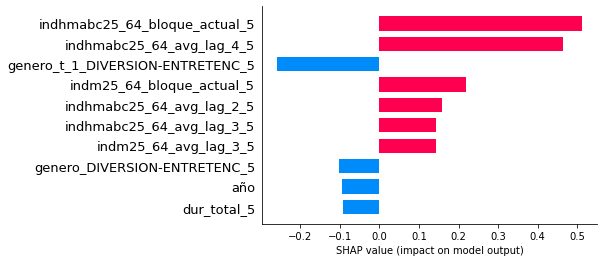

In [37]:
shap.bar_plot(shap_values[-1,:],
              feature_names=X_train_i.columns,
              max_display=10,show=False)


plt.savefig('Bar_Plot.png',dpi=150, bbox_inches='tight')

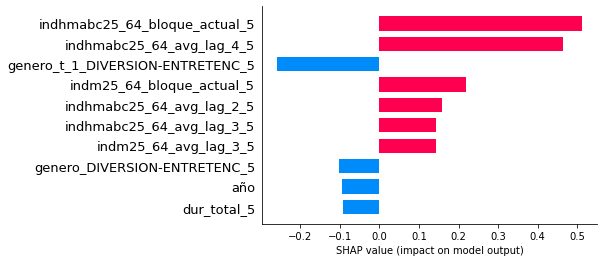

In [38]:
shap.bar_plot(shap_values[-1,:],
              feature_names=X_train_i.columns,
              max_display=10)

## Waterfall Plot
The second chart that we'll explain is a waterfall chart which shows how shap values of individual features are added to the base value in order to generate a final prediction. Below is a list of important parameters of the waterfall_plot() method.

expected_value - It accepts base value on which shap values will be added. The explainer object has a property named expected_value which needs to be passed to this parameter.
shap_values - It accepts an array of shap values for an individual sample of data.
feature_names - It accepts a list of feature names.
max_display -It accepts integer specifying how many features to display in a bar chart.
Below we have generated a waterfall plot for the first explainer object which does not consider the interaction between objects.

In [39]:
shap.waterfall_plot(explainer(X_train_i.iloc[-1:,:])
                    #explainer.shap_values(X_train_i.iloc[-1:,:]),
                    #feature_names=X_train_i.columns,
                    #max_display=20
                   )

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

## Decision Plot
The decision plot shows like the waterfall chart show the decision path followed by applying the shap values of individual features one by one to the expected value in order to generate predicted value as a line chart.

The decision plot can be used to show a decision path followed for more than one sample as well. Below is a list of important parameters of the decision_plot() method.

expected_value - It accepts base value on which shap values will be added. The explainer object has a property named expected_value which needs to be passed to this parameter.
shap_values - It accepts an array of shap values for an individual sample of data.
feature_names - It accepts a list of feature names.
feature_order - It accepts a list of below values as input and orders feature accordingly.

importance - Default Value. Orders feature according to the importance
hcluse - Hierarchical Clustering
none
list of array of indices
highlight - It accepts a list of indexes specifying which samples to highlight from the list of samples.

link - It accepts string specifying type of transformation used for the x-axis. It accepts one of the below values.

identity
logit
plot_color - It accepts matplotlib colormap to use to the color plot.

color_bar - It accepts boolean value specifying whether to display color bar or not.
Below we have drawn the decision plot of a single sample from the test dataset using the first linear explainer.

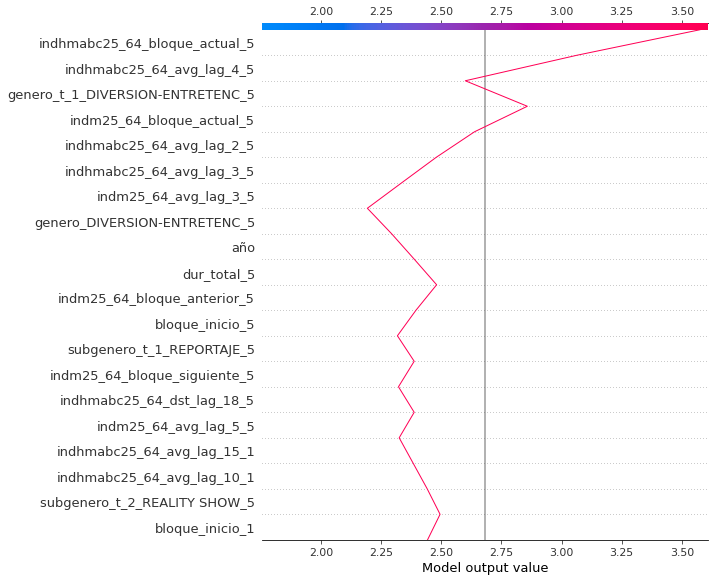

In [40]:
shap.decision_plot(explainer.expected_value,
                   explainer.shap_values(X_train_i.iloc[-1:,:]),
                   feature_names=X_train_i.columns.tolist(),show=False
                   )
plt.savefig("decision_plot.png",dpi=150, bbox_inches='tight')

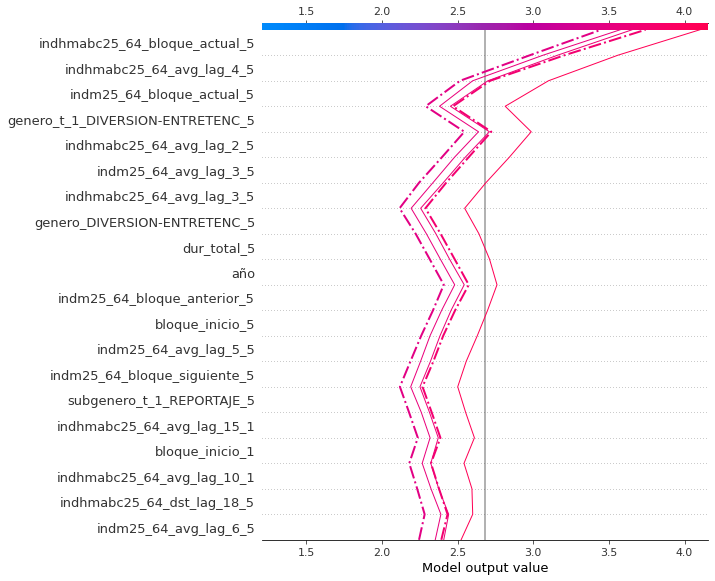

In [41]:
shap.decision_plot(explainer.expected_value,
                   explainer.shap_values(X_train_i.iloc[-5:,:]),
                   feature_names=X_train_i.columns.tolist(),
                   highlight=[1, 2],show=False
                   )

plt.savefig("decision_plot2.png",dpi=150, bbox_inches='tight')

## Dependence Plot
The dependence plot shows the relation between actual feature value and shap values for a particular feature of the dataset. We can generate a dependence plot using the dependence_plot() method. Below is a list of important parameters of the dependence_plot() method.

ind - It accepts either integer specifying the index of feature from data or string specifying the name of the feature. For future names given as a string, we need to provide feature names as a list to parameter feature_names.
shap_values - It accepts an array of shap values for an individual sample of data.
features - It accepts dataset which was used to generate shap values given to the shap_values parameter.
feature_names - It accepts a list of feature names.
Below we have generated a dependence plot for the CRIM feature using our first linear explainer. It's also showing the interaction of feature with feature AGE whose values are shown as a color bar.

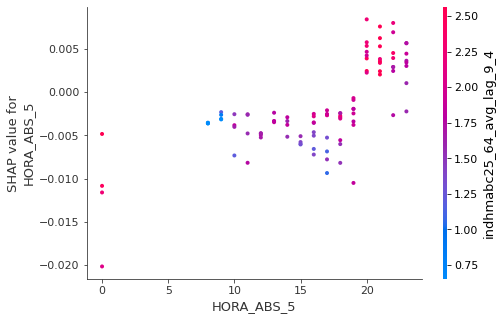

In [42]:
shap.dependence_plot(X_train_i.columns[0], shap_values[-100:,:], X_train_i.iloc[-100:,:],show=False)
plt.savefig("depencedence_plot.png",dpi=150, bbox_inches='tight')

## Force Plot
The force plot shows shap values contributions in generating final prediction using an additive force layout. It shows which features contributed to how much positively or negatively to base value to generate a prediction.

We can generate force plot using force_plot() method. Below are list of important parameters for force_plot() method.

expected_value - It accepts base value on which shap values will be added. The explainer object has a property named expected_value which needs to be passed to this parameter.
shap_values - It accepts an array of shap values for an individual sample of data.
feature_names - It accepts a list of feature names.
out_names - It accepts string specifying target variable name.
Below we have generated a force plot of the first test sample using the first linear explainer. We can see the magnitude of positivity and negativity of features in the chart.

In [43]:
shap.force_plot(explainer.expected_value, shap_values[-1,:], X_train_i.iloc[-1,:],
                feature_names=X_train_i.columns.tolist(),
                out_names="Rating",show=False)
plt.savefig("force_plot.png",dpi=150, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [44]:
shap.force_plot(explainer.expected_value, shap_values[-1,:], X_train_i.iloc[-1,:],
                feature_names=X_train_i.columns.tolist(),
                out_names="Rating")

In [45]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[-10:,:], X_train_i.iloc[-10:,:],
                feature_names=X_train_i.columns.tolist(),
                out_names="Rating",show=False)

plt.savefig("force_plot2.png",dpi=150, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

Below we have generated a force plot of 10 samples of the dataset using the first linear explainer. It also provides us with a dropdown on Y-axis which we can change to see the impact of the individual feature on all 10 predictions. In this chart, y-axis values represent predicted values for each sample and the x-axis represents 10 samples from 0-9.

In [46]:
shap.force_plot(explainer.expected_value, shap_values[-5:,:], X_train_i.iloc[-5:,:],
                feature_names=X_train_i.columns.tolist(),
                out_names="Rating", figsize=(25,3),
                link="identity",show=False)

## Summary Plot
The summary plot shows the beeswarm plot showing shap values distribution for all features of data. We can also show the relationship between the shap values and the original values of all features.

We can generate summary plot using summary_plot() method. Below are list of important parameters of summary_plot() method.

shap_values - It accepts array of shap values for individual sample of data.
features - It accepts dataset which was used to generate shap values given to shap_values parameter.
feature_names - It accepts list of feature names.
max_display -It accepts integer specifying how many features to display in bar chart.
plot_type - It accepts one of the below strings as input.
dot (default for single output)
bar - (default for multiple output)
violin
Below we have generated a summary plot of shap values generated from the test dataset using the first linear explainer. We can see a distribution of shap values and their relation with actual feature values based on the color bar on the right side.

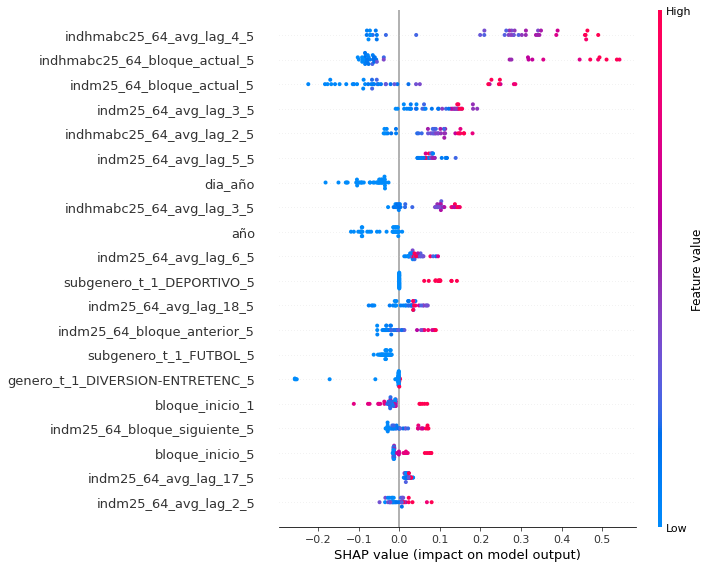

In [47]:
shap.summary_plot(explainer.shap_values(X_train_i.iloc[-40:,:]),
                  features = X_train_i.iloc[-40:,:],
                  feature_names=X_train_i.columns.tolist(),show=False)

plt.savefig("summary_plot.png",dpi=150, bbox_inches='tight')

Below we have generated a summary plot with plot type as bar based on shape values generated from test data using the first linear explainer. The bar chart shows the average impact of each feature on the final prediction. This also highlights feature importance based on shap values.

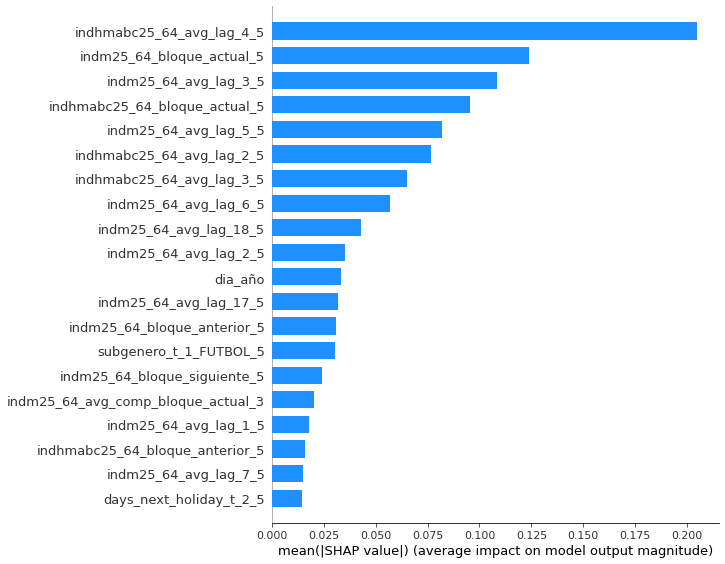

In [48]:
shap.summary_plot(explainer.shap_values(X_test_i.iloc[-40:,:]),
                  features = X_test_i.iloc[-40:,:],
                  feature_names=X_train_i.columns.tolist(),
                 plot_type='bar',
                 color='dodgerblue',show=False)

plt.savefig("summary_plot2.png",dpi=150, bbox_inches='tight')

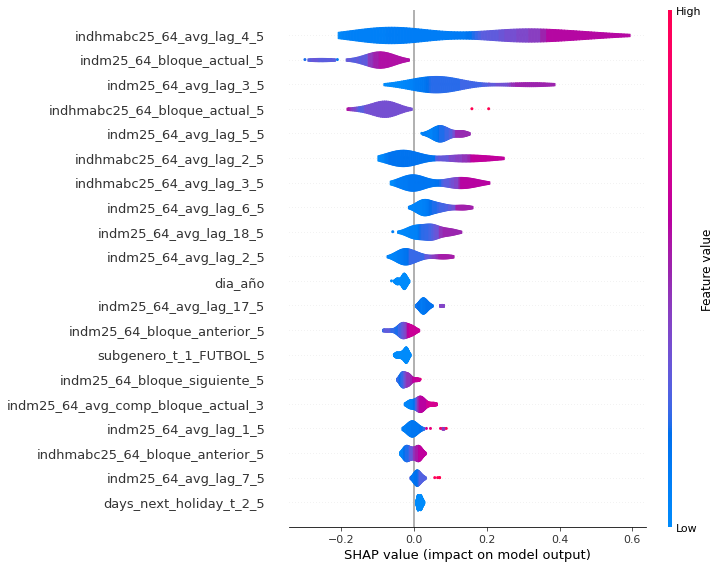

In [49]:
shap.summary_plot(explainer.shap_values(X_test_i.iloc[-40:,:]),
                  features = X_test_i.iloc[-40:,:],
                  feature_names=X_train_i.columns.tolist(),
                 plot_type='violin',
                 color='tomato',show=False)

plt.savefig("summary_plot3.png",dpi=150, bbox_inches='tight')

In [50]:
#reg.save_model('save_model/2020_35_t1_target_1.model')

## Classic feature attributions


The xgboost provides functionality that lets us print feature importance. We need to pass our booster instance to the method and it'll plot feature importance bar chart using matplotlib. The plot_importance() method has an important parameter named importance_type which accepts one of the below mentioned 3 string values to plot feature importance in three different ways.

weight - It plots the number of times a feature appears in a tree. This is the default value.
gain - It plots the average gain of splits that uses the feature.
cover - It plots the average coverage of splits for each feature.

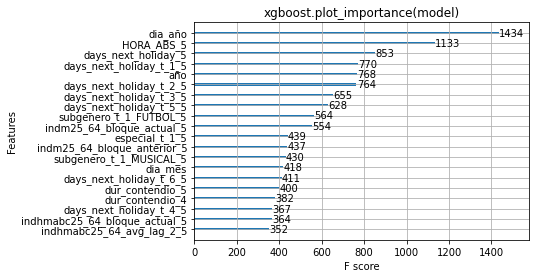

In [25]:
plot_importance(reg, max_num_features=20)
pl.title("xgboost.plot_importance(model)")
pl.show()

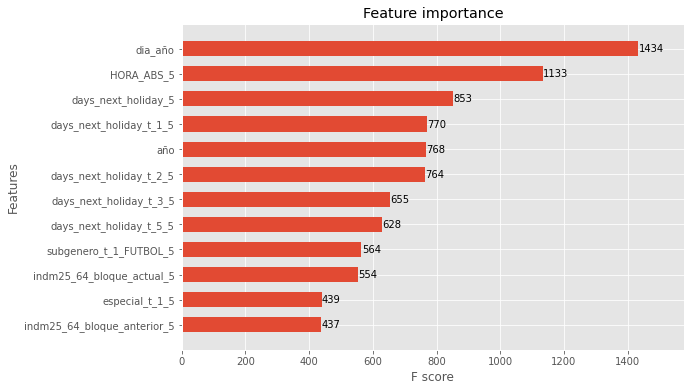

In [51]:
#plot_importance()
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    plot_importance(reg, ax=ax, height=0.6, importance_type="weight", max_num_features=12)
    plt.savefig("importance_plot.png",dpi=150, bbox_inches='tight')

In [27]:
reg.feature_importances_

array([2.0083973e-04, 2.8060389e-05, 6.7951507e-05, ..., 9.4246224e-04,
       8.1445911e-04, 5.7196175e-04], dtype=float32)

### plot_tree

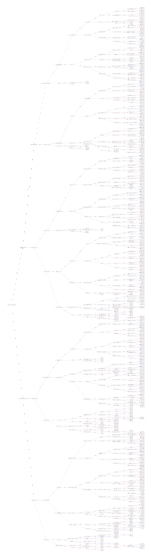

<Figure size 432x288 with 0 Axes>

In [29]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(111)
    plot_tree(reg, ax=ax, num_trees=0, rankdir='LR')
    #xgb.to_graphviz(reg, num_trees=3, rankdir='LR')
    plt.show()
    
    plt.savefig("tree_plot.pdf",dpi=150, bbox_inches='tight')

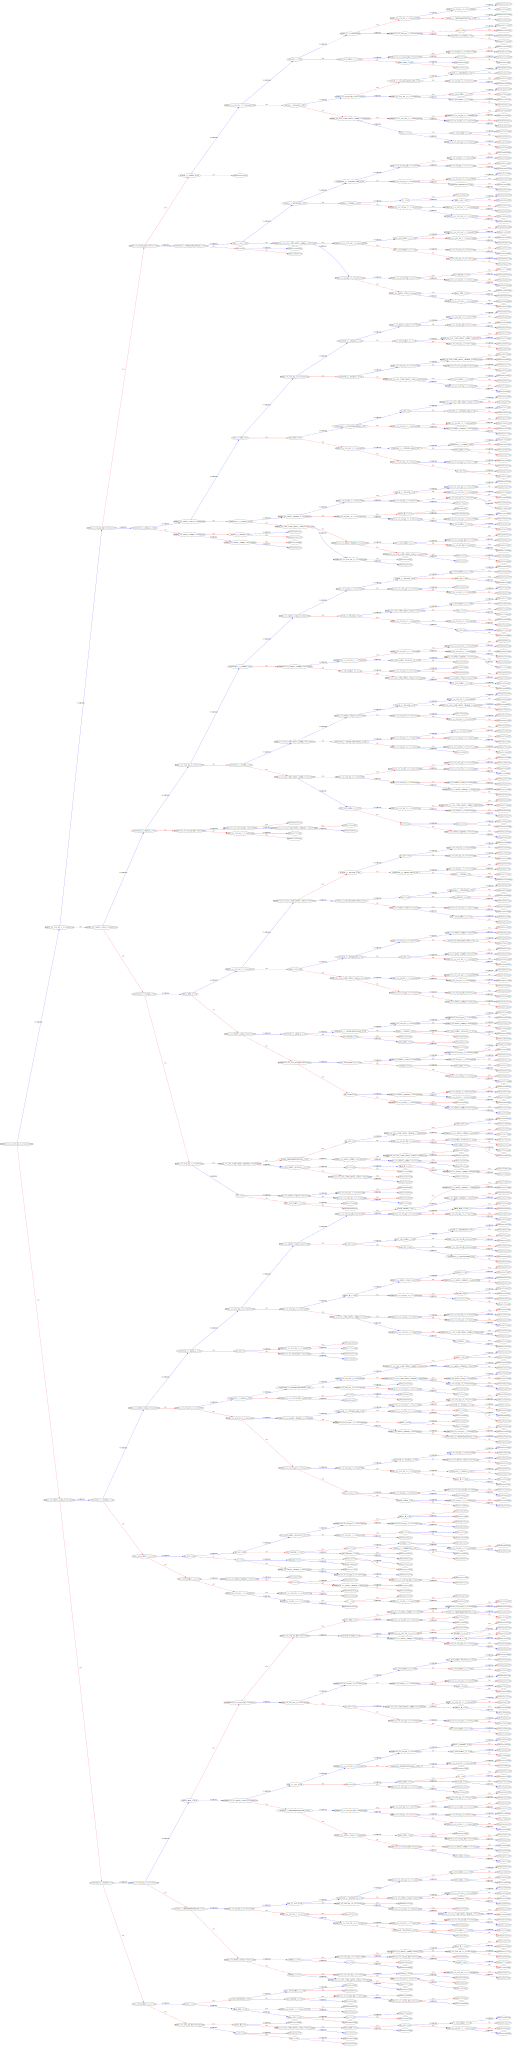

In [29]:
xgb.to_graphviz(reg, num_trees=1, rankdir='LR')
#plt.savefig("tree_plot.png")

## get_split_value_histogram()
The get_split_value_histogram() method returns histogram of splits for feature values. Below we have created split values histogram for feature LSTAT of data. It gives us value and how many times a split has happened at that value.

In [ ]:
reg1=xgb.train({'max_depth': 3, 'eta': 1, 'objective': 'reg:squarederror'},
                    X_train_i)

In [30]:
reg.get_split_value_histogram("LSTAT")

AttributeError: 'XGBRegressor' object has no attribute 'get_split_value_histogram'

## trees_to_dataframe()
The trees_to_dataframe() method will dump information on trees used in an ensemble as a pandas dataframe. It'll have information on each tree-like individual node ids, feature name, and its values used for a split at each node, gain at each node, cover at each node, etc.

In [ ]:
reg1.trees_to_dataframe()